In [1]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import datetime

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
import os
from tqdm import tqdm_notebook

chromedriver = "/home/gavin/Downloads/chromedriver"
os.environ["webdriver.chrome.driver"] = chromedriver

rsetex=re.compile(r'(.+) \((Common|Uncommon|Rare|Mythic Rare)\)')

pt_cmc_re = re.compile(r'(?:Legendary )?(?:Snow )?(?:Artifact |Enchantment )?Creature — (?:[a-zA-Z\-]+ )+([0-9\*\+\-]+)/([0-9\*\+\-]+),.* (?:\(?([0-9]+)\)?|X+)\n.*', flags=re.DOTALL)

evergreen=['flying','flash','first strike','double strike','vigilance','hexproof','haste','trample','reach','menace','indestructible','deathtouch','lifelink','defender','prowess']
evergreen_re=[re.compile('('+x[0].upper()+'|'+x[0]+')'+x[1:]) for x in evergreen]
evergreen_titles=[''.join([x[0].upper()+x[1:] for x in y.split(' ')]) for y in evergreen]

%matplotlib inline

In [ ]:
driver = webdriver.Chrome(chromedriver)

### These are the sets I'm working with

In [ ]:
setdict={'10e': datetime.datetime(2007, 7, 1, 0, 0),
 '5dn': datetime.datetime(2004, 6, 1, 0, 0),
 '9ed': datetime.datetime(2005, 7, 1, 0, 0),
 'aer': datetime.datetime(2017, 1, 1, 0, 0),
 'akh': datetime.datetime(2017, 4, 1, 0, 0),
 'ala': datetime.datetime(2008, 9, 1, 0, 0),
 'arb': datetime.datetime(2009, 4, 1, 0, 0),
 'avr': datetime.datetime(2012, 5, 1, 0, 0),
 'bfz': datetime.datetime(2015, 10, 1, 0, 0),
 'bng': datetime.datetime(2014, 2, 1, 0, 0),
 'bok': datetime.datetime(2005, 2, 1, 0, 0),
 'chk': datetime.datetime(2004, 10, 1, 0, 0),
 'con': datetime.datetime(2009, 2, 1, 0, 0),
 'csp': datetime.datetime(2006, 7, 1, 0, 0),
 'dgm': datetime.datetime(2013, 5, 1, 0, 0),
 'dis': datetime.datetime(2006, 5, 1, 0, 0),
 'dka': datetime.datetime(2012, 2, 1, 0, 0),
 'dst': datetime.datetime(2004, 2, 1, 0, 0),
 'dtk': datetime.datetime(2015, 3, 1, 0, 0),
 'emn': datetime.datetime(2016, 7, 1, 0, 0),
 'eve': datetime.datetime(2008, 6, 1, 0, 0),
 'frf': datetime.datetime(2015, 1, 1, 0, 0),
 'fut': datetime.datetime(2007, 5, 1, 0, 0),
 'gpt': datetime.datetime(2006, 2, 1, 0, 0),
 'gtc': datetime.datetime(2013, 2, 1, 0, 0),
 'hou': datetime.datetime(2017, 7, 1, 0, 0),
 'isd': datetime.datetime(2011, 9, 1, 0, 0),
 'jou': datetime.datetime(2014, 5, 1, 0, 0),
 'kld': datetime.datetime(2016, 9, 1, 0, 0),
 'ktk': datetime.datetime(2014, 10, 1, 0, 0),
 'lrw': datetime.datetime(2007, 10, 1, 0, 0),
 'm10': datetime.datetime(2009, 7, 1, 0, 0),
 'm11': datetime.datetime(2010, 7, 1, 0, 0),
 'm12': datetime.datetime(2011, 7, 1, 0, 0),
 'm13': datetime.datetime(2012, 7, 1, 0, 0),
 'm14': datetime.datetime(2013, 7, 1, 0, 0),
 'm15': datetime.datetime(2014, 7, 1, 0, 0),
 'mbs': datetime.datetime(2011, 2, 1, 0, 0),
 'mor': datetime.datetime(2008, 2, 1, 0, 0),
 'mrd': datetime.datetime(2003, 10, 1, 0, 0),
 'nph': datetime.datetime(2011, 5, 1, 0, 0),
 'ogw': datetime.datetime(2016, 1, 1, 0, 0),
 'ori': datetime.datetime(2015, 7, 1, 0, 0),
 'plc': datetime.datetime(2007, 2, 1, 0, 0),
 'rav': datetime.datetime(2005, 10, 1, 0, 0),
 'roe': datetime.datetime(2010, 4, 1, 0, 0),
 'rtr': datetime.datetime(2012, 10, 1, 0, 0),
 'shm': datetime.datetime(2008, 5, 1, 0, 0),
 'soi': datetime.datetime(2016, 4, 1, 0, 0),
 'sok': datetime.datetime(2005, 6, 1, 0, 0),
 'som': datetime.datetime(2010, 10, 1, 0, 0),
 'ths': datetime.datetime(2013, 9, 1, 0, 0),
 'tsp': datetime.datetime(2006, 10, 1, 0, 0),
 'wwk': datetime.datetime(2010, 2, 1, 0, 0),
 'xln': datetime.datetime(2017, 9, 1, 0, 0),
 'zen': datetime.datetime(2009, 10, 1, 0, 0)}

### These functions process one page for its card information, and one full set, respectively

In [ ]:
def ProcessPage(setcode, cardnum):
    outdict = {}
    url='https://magiccards.info/'+setcode+'/en/'+str(cardnum)+'.html'
    thispage=requests.get(url).text
    thissoup = BeautifulSoup(thispage, 'lxml')
    if (not re.search('Creature —',thispage)) or re.search("Color Indicator", thispage):
        return None
    driver.get(url)
    time.sleep(0.25)
    try:
        midprice = driver.find_element_by_class_name('TCGPHiLoMid')
    except:
        return None
    outdict['Price']=float(midprice.text[4:])
    
    power, toughness, cmc = pt_cmc_re.match(thissoup.find('p', text=pt_cmc_re).text).groups()
    setname, rarity = rsetex.match(thissoup.find('b', text=rsetex).text).groups()
    try:
        outdict['Power']=int(power)
        outdict['Toughness']=int(toughness)
    except ValueError:
        outdict['Power']=0
        outdict['Toughness']=0
    try:
        outdict['CMC']=int(cmc)
    except TypeError:
        outdict['CMC']=0
    outdict['SetName']=setname
    outdict['Rarity']=rarity
    
    tbox=thissoup.find('p',class_='ctext').text
    outdict['WordCount']=len(tbox.split(' '))
    for name,rex in zip(evergreen_titles, evergreen_re):
        outdict['Has'+name]=bool(rex.search(tbox))
    outdict["Banned"]=bool(re.search('Banned in ',thispage))
    outdict["Standard"] = bool(re.search('Legal in Standard', thispage))
    return outdict

In [ ]:
def ProcessSet(setcode):
    url='https://magiccards.info/'+setcode+'/en.html'
    thispage=requests.get(url).text
    cardmatch = re.search('([0-9]+) cards', thispage)
    if not bool(cardmatch):
        return None
    cards=[]
    for i in tqdm_notebook(range(1,int(cardmatch.groups()[0])-1), leave=False):
        cardstuff=ProcessPage(setcode,i)
        if bool(cardstuff):
            cardstuff['SetCode']=setcode
            cardstuff['ReleaseDate']=setdict[setcode]
            cards.append(cardstuff)
    return cards

### This is the code that loops over all sets

In [ ]:
allframes=[]
badnames=[]
for setcode in tqdm_notebook(setdict.keys(), total=len(setdict)):
    try:
        newframe = pd.DataFrame(ProcessSet(setcode))
        allframes.append(newframe)
    except:
        badnames.append(setcode)

In [ ]:
fulltable=pd.concat(allframes)

In [ ]:
fulltable.to_pickle('/home/gavin/Metis/card_data')

In [2]:
from sklearn import linear_model
import datetime as dt
from sklearn import model_selection
%matplotlib inline

### Most of this is modifying columns so they work better for regression

In [3]:
cardtable=pd.read_pickle('/home/gavin/Metis/card_data')
alphatime=dt.datetime(1993,8,5)
cardtable['ReleaseDays'] = cardtable['ReleaseDate'].map(lambda x:(x-alphatime).days)

In [4]:
cardtable['IsUncommon']=(cardtable.Rarity=='Uncommon')
cardtable['IsRare']=(cardtable.Rarity=='Rare')
cardtable['IsMythic']=(cardtable.Rarity=='Mythic Rare')
cardtable['LogPrice']=np.log(cardtable.Price)

In [5]:
test=cardtable.sample(1).iloc[0]
NumCols=[x for x in test.index if isinstance(test[x], np.int64) or isinstance(test[x], np.float64) or isinstance(test[x], np.bool_)]
DataCols=list(NumCols)[:]
DataCols.remove('Price')
DataCols.remove('LogPrice')

In [6]:
cardnums=cardtable[DataCols]

### Our first linear model

In [7]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    cardnums, cardtable.LogPrice, test_size=0.2, random_state=0)

In [8]:
reg2=linear_model.LinearRegression(normalize=True)
reg2.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [9]:
reg2.score(X_test, y_test)

0.65504344840728068

In [10]:
np.exp(np.sqrt(((y_test-reg2.predict(X_test))**2).mean()))

1.8936185163597734

### Our second linear model, with regularization

In [11]:
ridgemodel=linear_model.RidgeCV(cv=3,
    alphas=([10.0**n for n in range(-12,3,2)]),
    normalize=True)
ridgemodel.fit(X_train, y_train)

RidgeCV(alphas=[1e-12, 1e-10, 1e-08, 1e-06, 0.0001, 0.01, 1.0, 100.0], cv=3,
    fit_intercept=True, gcv_mode=None, normalize=True, scoring=None,
    store_cv_values=False)

In [12]:
colortable=cardtable[["IsUncommon","IsRare","IsMythic"]]

### Plotting the errors in the Ridge model

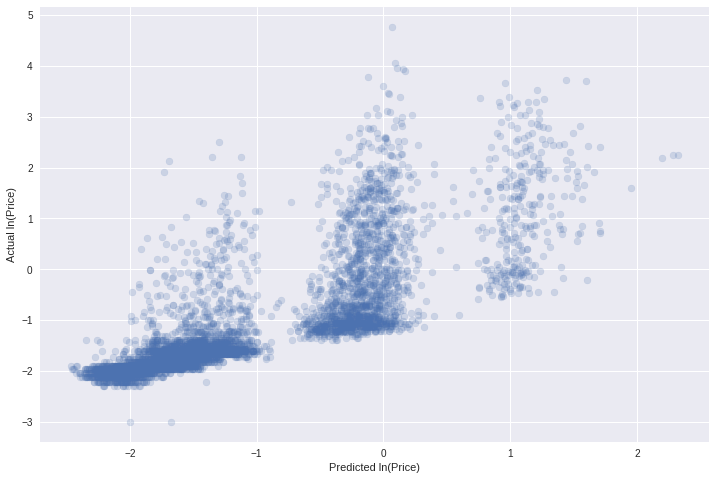

In [13]:
plt.figure(figsize=(12,8))
plt.scatter(ridgemodel.predict(cardnums),
            cardtable.LogPrice, alpha=0.2)
plt.xlabel('Predicted ln(Price)')
plt.ylabel('Actual ln(Price)')

plt.savefig('before_errors.png')

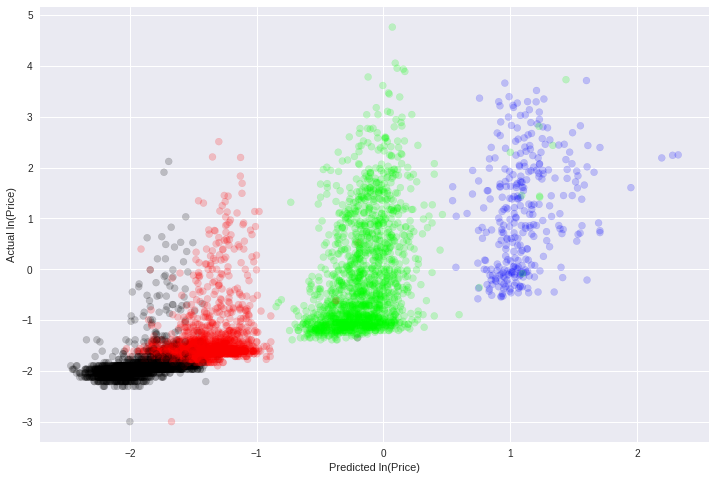

In [14]:
plt.figure(figsize=(12,8))
plt.scatter(ridgemodel.predict(cardnums),
            cardtable.LogPrice, alpha=0.2, c=colortable)
plt.xlabel('Predicted ln(Price)')
plt.ylabel('Actual ln(Price)')

plt.savefig('after_errors.png')

### A simpler model with nearly the same R-squared

In [15]:
simplelinear=linear_model.LinearRegression(normalize=True)
simplelinear.fit(X_train[["IsUncommon","IsRare","IsMythic",'ReleaseDays']], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

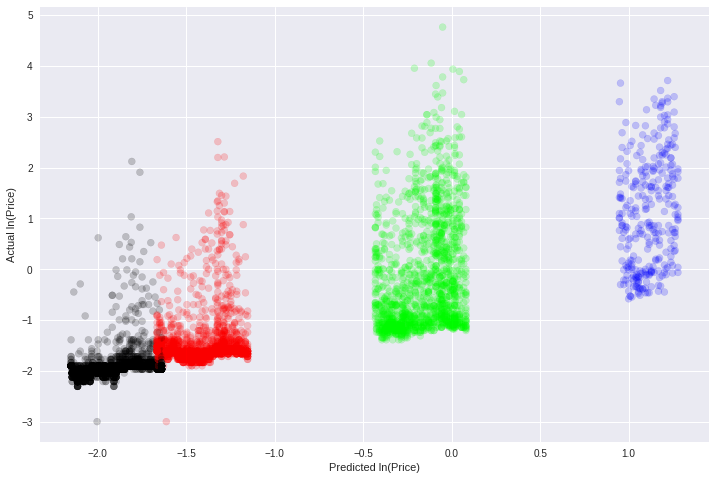

In [16]:
plt.figure(figsize=(12,8))
plt.scatter(simplelinear.predict(cardtable[["IsUncommon","IsRare","IsMythic",'ReleaseDays']]),
            cardtable.LogPrice, alpha=0.2, c=colortable)
plt.xlabel('Predicted ln(Price)')
plt.ylabel('Actual ln(Price)')

plt.savefig('clean_errors.png')

In [17]:
np.exp(pd.Series(simplelinear.coef_*np.array([1,1,1,365]), index=["IsUncommon","IsRare","IsMythic",'ReleaseDays']))

IsUncommon      1.625954
IsRare          5.582211
IsMythic       22.166641
ReleaseDays     0.963929
dtype: float64

In [18]:
np.exp(np.sqrt(((y_test - simplelinear.predict(X_test[["IsUncommon","IsRare","IsMythic",'ReleaseDays']]))**2).mean()))

1.9142959065231253

In [19]:
simplelinear.score(X_test[["IsUncommon","IsRare","IsMythic",'ReleaseDays']],y_test)

0.6432086373632625

### The price of a card right now, according to model, by rarity

In [20]:
np.exp(simplelinear.predict(
    pd.DataFrame([[0,0,0,8800],[1,0,0,8800],[0,1,0,8800],[0,0,1,8800]],
    index=["IsUncommon","IsRare","IsMythic",'ReleaseDays'])))

array([ 0.1163174 ,  0.18912669,  0.64930824,  2.57836604])